## Nature's Cost Function: Finding Paths of Least Action with Gradient Descent
Tim Strang, Isabella Caruso, and Sam Greydanus | 2023 | MIT License

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from main import * # SimOpt code
DPI=60

In [98]:
def make_video(xs, path, interval=60, ms=10, colors=None, **kwargs): # xs: [time, N, 2]
    if colors is None and len(xs.shape)==3 and xs.shape[1] <= 3:
        colors = [(0.5,0,0), (0,0,0.5), (0,0.5,0)]
    fig = plt.gcf() ; fig.set_dpi(100) ; fig.set_size_inches(3, 3)
    camera = Camera(fig)
    for i in range(xs.shape[0]):
        for j in range(xs[i].shape[0]):
            color = colors[j] if colors and len(colors) >= xs.shape[1] else 'black'
            plt.plot(xs[i][j,0], xs[i][j,1], 'k.', color=color, markersize=ms)
        plt.axis('equal') ; plt.xlim(0,1) ; plt.ylim(0,1)
        plt.xticks([], []); plt.yticks([], [])
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path) ; plt.close()

In [70]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    alpha = .7
    plot_config = [(S, 'k', '$S$', alpha), (T, 'r', '$\sum_i T_i$', alpha),
                   (-np.asarray(V), 'b', '$-\sum_i V_i$', alpha),
                   (S_ode, 'k:', '$S$ (ODE)', 1), (T_ode, 'r:', '$-\sum_i T_i$ (ODE)', 1),
                   (-V_ode, 'b:', '$-\sum_i V_i$ (ODE)', 1)]
    N = len(S)
    for i, (x, fmt, label, alpha) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, alpha=alpha, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, alpha=alpha, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels, fontsz, legend=False):
    #plt.title(ax_labels['title'], fontweight="bold")
    if legend:
        plt.legend(ncol=2, fontsize=fontsz['legend'])
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, name, fontsz, ax_labels, L_fn, legend=False, fig=None, ylim=(None, None)):
    fig = plt.figure(figsize=(6, 5.5), dpi=DPI)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.tensor(x_sim), L_fn=L_fn, dt=dt)
    print(f'{T_ode.sum()}, {V_ode.sum()}, {S_ode.sum()}')
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode.sum(), T_ode.sum(), V_ode.sum())
    plt.ylim(ylim[0], ylim[1])
    path ='./static/action_{}.pdf'.format(name.lower().replace(' ', ''))
    plot_helper(ax, ax_labels, fontsz, legend=legend)
    plt.show()
    if DPI > 250: fig.savefig(path)

def unity(x):
    return x

def dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=unity, ylim=(None, None)):
    fig = plt.figure(figsize=(7, 5), dpi=DPI) 
#     fig = plt.figure(figsize=(6, 5.5), dpi=DPI)
    ax = fig.add_subplot(111)
    ax.plot(t_sim, plt_fn(x_sim), '.-', color='purple', label='ODE solution', linewidth=4, markersize=12)
    ax.plot(t_sim, plt_fn(x_sim), '.-', color='purple')
    ax.plot(t_min, plt_fn(xs_min[0]), 'y-', alpha=.3, label='Initial (random) path')
    for i, xi in enumerate(xs_min):
        label = 'During optimization' if i==10 else None
        ax.plot(t_min, plt_fn(xi), '-', alpha=.4, #+ .7 * i/(len(xs_min)-1)
                color=plt.cm.viridis(1-i/(len(xs_min)-1)), label=label, linewidth=2)
    ax.plot(t_min, plt_fn(xs_min[-1]), 'g.-', label='Final (optimized) path', linewidth=4, markersize=12)
    ax.plot(t_min[[0,-1]], plt_fn(xs_min[0])[[0,-1]], 'g+', markersize=12,
            label='Points held constant', linewidth=4)

    plt.ylim(ylim[0], ylim[1])
    
    plot_helper(ax, ax_labels, fontsz, legend = name=='Free body')
    path ='./static/dynamic_{}.pdf'.format(name.lower().replace(' ', ''))
    #plt.show() ; fig.savefig(path)
    for item in [0, -1]:
        print(torch.mean(torch.square(torch.from_numpy(x_sim) - xs_min[item].reshape(x_sim.shape))).item())

## Free body

In [71]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam', verbose=False)

629.659136743838
0.3518336615811058


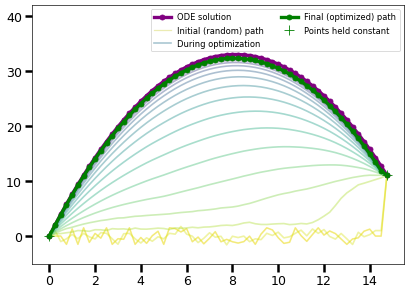

In [72]:
name = 'Free body'
fontsz = {'title': 23, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Free Body Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}
dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, ylim=(-5, 42))

9.540104166666666, 23.354166666666668, -13.814062500000002


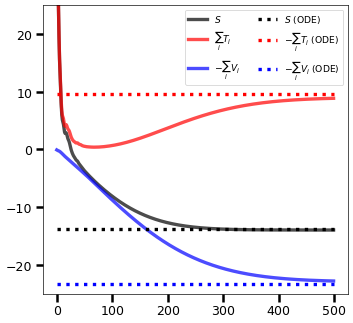

In [73]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 17, 'x_label': 23, 'y_label': 28, 'legend': 11}
fig = action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_freebody, legend=True, ylim=(-25, 25))

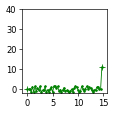

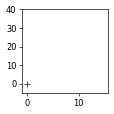

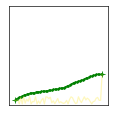

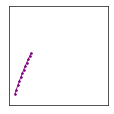

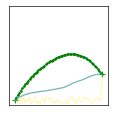

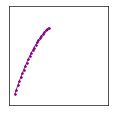

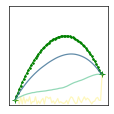

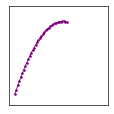

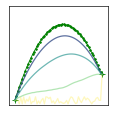

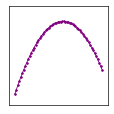

In [74]:
path = 'static'

def simplot(i, x_sim, min_slice):
    steps = int(len(x_sim)*min_slice[i]/15)
    fig = plt.figure(figsize=(2, 2), dpi=DPI)
    ax=fig.add_subplot(111)
    if i==0:
        plt.plot(t_sim[:1], x_sim[:1], '+', color='purple', markersize=8)
    plt.scatter(t_sim[:steps], x_sim[:steps], color='purple', s=4)
    plt.plot(t_sim[:steps], x_sim[:steps], color='purple', linewidth=1)
    plt.xlim(-1, t_sim.max()+1)
    plt.ylim(-5, 40)
    if i != 0:
        plt.xticks([], []) ; plt.yticks([], []) # SJG comment - this approach works better
        #plt.tick_params(axis='y', labelcolor='w')
    
    plt.tight_layout()
    if DPI > 250: fig.savefig(path + f'/hero_sim_{steps}.pdf')

def minplot(i, min_slice):
    fig = plt.figure(figsize=(2, 2), dpi=DPI)
    plt.scatter(t_min, xs_min[int(min_slice[i])], color='g', s=4)
    plt.plot(t_min, xs_min[int(min_slice[i])], 'g', linewidth=1)
    plt.xlim(-1, t_min.max()+1)
    plt.ylim(-2, 40)
    #plt.title(f'Step {min_slice[i]}', fontweight='bold')
    plt.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'g+', markersize=7)
    plt.xticks([0, 5, 10, 15])
    
    if i != 0:
        plt.xticks([], []) ; plt.yticks([], [])
            
    j = i
    while j>0:
        j = j-1
        slc= int(min_slice[j])
        plt.plot(t_min, xs_min[slc], alpha=.3 + .7*j/i, color=plt.cm.viridis(1-j/i))
    plt.tight_layout()
    if DPI > 250: fig.savefig(path + f'/hero_min_{4*min_slice[i]}.pdf')
    

min_slice=[0, 3, 6, 9, 15]
for i in range(5):
    minplot(i, min_slice)
    simplot(i, x_sim, min_slice)

## Single pendulum

In [75]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=2.0e-1, zero_basepath=False) # [time, N*2]
init_path.x.data[2:-2] = init_path.x.data[2:-2]*.7
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=5e-2, L_fn=lagrangian_pend,
                                            dt=dt, opt='adam', print_updates=15, verbose=False, e_coeff=1e2)

0.11844894530187806
0.012020897098183703


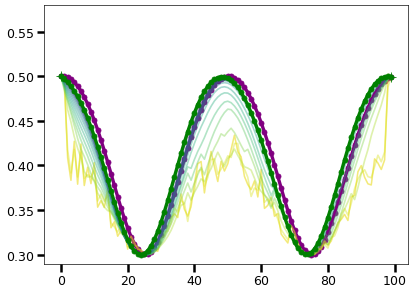

In [76]:
def pend_height(xs):
    return radial2cartesian_pend(xs)[...,1]

name = 'Pendulum'
fontsz = {'title': 19, 'x_label': 23, 'y_label': 23, 'legend': 9.75}
ax_labels = {'title':'Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=pend_height, ylim=(None, 0.58))

81.9045014556287, 98.2431153230458, -16.338613867417095


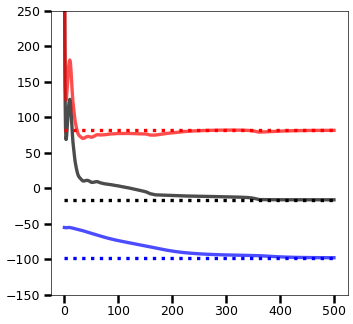

In [77]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 28, 'legend': 12}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_pend, ylim=(-150, 250), legend=False)

xy = radial2cartesian_pend(x_sim)
make_video(xy, path='./static/video_pendulum.mp4', interval=60, ms=20)
mp4 = open('./static/video_pendulum.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

## Double pendulum
This `dblpend_dynamic_plot` reproduces code from the `dynamic_plot` function above, but with a few modifications which permit plotting of both bobs. Not the cleanest approach, but we used it to make the figure slightly better.

In [78]:
def dblpend_dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=unity, ylim=(None, None)):
    fig = plt.figure(figsize=(7, 5), dpi=DPI) 
    ax = fig.add_subplot(111)
    ax.plot(t_sim, plt_fn(x_sim)[:, 0, 1], '.-', color='purple', 
            label='ODE solution', linewidth=4, markersize=12)
    ax.plot(t_sim, plt_fn(x_sim)[:, 1, 1], '.-', color='purple', linewidth=4, markersize=12)
    
    ax.plot(t_min, plt_fn(xs_min[0])[:, 0, 1], 'y-', alpha=.3, label='Initial (random) path')
    ax.plot(t_min, plt_fn(xs_min[0])[:, 1, 1], 'y-', alpha=.3)
    for i, xi in enumerate(xs_min):
        label = 'During optimization' if i==10 else None
        ax.plot(t_min, plt_fn(xi)[:, 0, 1], '-', alpha=.4, 
                color=plt.cm.viridis(1-i/(len(xs_min)-1)), label=label, linewidth=2)
        ax.plot(t_min, plt_fn(xi)[:, 1, 1], '-', alpha=.4, 
                color=plt.cm.viridis(1-i/(len(xs_min)-1)), label=label, linewidth=2)
    ax.plot(t_min, plt_fn(xs_min[-1])[:, 0, 1], 'g.-', alpha=.4, 
                 label='Final (optimized) path', linewidth=4, markersize=12)
    ax.plot(t_min, plt_fn(xs_min[-1])[:, 1, 1], 'g.-', alpha=.4, linewidth=4, markersize=12)
    ax.plot(t_min[[0,-1]], plt_fn(xs_min[0])[:, 0, 1][[0,-1]], 'g+', markersize=20,
            label='Points held constant')
    ax.plot(t_min[[0,-1]], plt_fn(xs_min[0])[:, 1, 1][[0,-1]], 'g+', markersize=20)

    plt.ylim(ylim[0], ylim[1])
    
    plot_helper(ax, ax_labels, fontsz, legend = name=='Free body')
    path ='./static/dynamic_{}.pdf'.format(name.lower().replace(' ', ''))
    plt.show()
    if DPI > 250: fig.savefig(path)

In [79]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=6e-1, zero_basepath=False)
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e-2, 
                                            L_fn=lagrangian_dblpend, dt=dt, opt='adam', verbose=False)

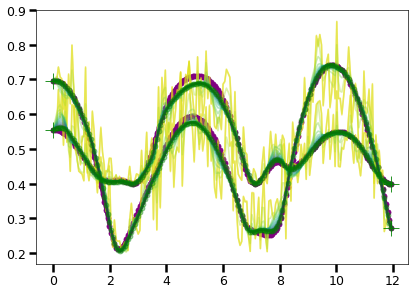

In [80]:
def dblpend_height(xs):
    return radial2cartesian_dblpend(xs)

name = 'Double Pendulum'
fontsz = {'title': 19, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Second Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}

dblpend_dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=dblpend_height)

1.5791820080976295, -1.0116185558267248, 2.590800563924354


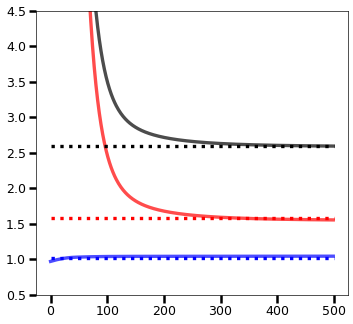

In [81]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_dblpend, ylim=(0.5, 4.5))

In [82]:
xy_0 = radial2cartesian_dblpend(xs_min[0])
make_video(xy_0, path='./static/video_doublependulum_0.mp4', interval=60, ms=20)
mp4 = open('./static/video_doublependulum_0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [83]:
xy_f = radial2cartesian_dblpend(xs_min[-1])
make_video(xy_f, path='./static/video_doublependulum_f.mp4', interval=60, ms=20)
mp4 = open('./static/video_doublependulum_f.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

## Three body problem

In [84]:
dt = 0.5 ; N = 3
t_sim, x_sim = simulate_3body(dt=dt, stable_config=False)
init_path = PerturbedPath(x_sim, N=N, sigma=3e-2) # [time, N*2]
init_path.x.data[3:-3] = init_path.x.data[3:-3] * 0.8 + 0.2
t_min, path, xs_min, info = minimize_action(init_path, steps=1000, step_size=2e-2, L_fn=lagrangian_3body,
                                            dt=dt, opt='adam', print_updates=10, e_coeff=0)

step=0000, S=3.711e-03 J*s, E_loss=0.000e+00, dt=0.0s
step=0100, S=7.169e-04 J*s, E_loss=0.000e+00, dt=2.9s
step=0200, S=7.057e-04 J*s, E_loss=0.000e+00, dt=2.9s
step=0300, S=6.991e-04 J*s, E_loss=0.000e+00, dt=3.2s
step=0400, S=6.966e-04 J*s, E_loss=0.000e+00, dt=3.1s
step=0500, S=6.945e-04 J*s, E_loss=0.000e+00, dt=3.2s
step=0600, S=6.943e-04 J*s, E_loss=0.000e+00, dt=3.0s
step=0700, S=6.944e-04 J*s, E_loss=0.000e+00, dt=3.2s
step=0800, S=6.948e-04 J*s, E_loss=0.000e+00, dt=3.2s
step=0900, S=6.948e-04 J*s, E_loss=0.000e+00, dt=2.8s


0.0002480689645546746, -0.00044614782706382296, 0.0006942167916184975


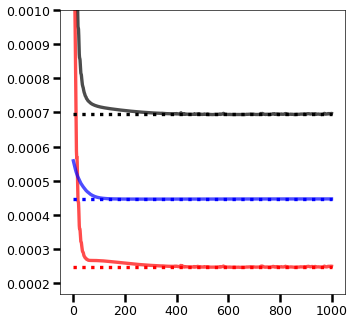

In [85]:
name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_3body, ylim=(.00017, .001))

0.009735116282444846
5.740191180361903e-06


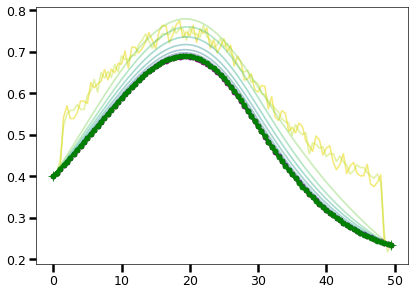

In [86]:
N = x_sim.shape[-2]
k=0
def ball_xcoord(xs, shape=x_sim.shape, k=k):
    return xs.reshape(shape)[:, 0, k]

ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}
dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=ball_xcoord)

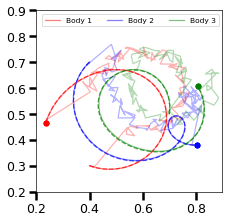

In [87]:
def plot_3body(x, do_bodies=False, colors=None, fig=None, fmt='-', legend=None, **kwargs):
    if fig is None:
        plt.figure(figsize=[4,4], dpi=DPI)
    if not colors:
        colors = ['red', 'blue', 'green']
    for i, c in enumerate(colors):
        plt.plot(x[:,i,0], x[:,i,1], fmt, color=c, label=f'Body {i+1}' if legend else None, **kwargs)
        if do_bodies:
            plt.plot(x[-1,i,0], x[-1,i,1], '.', color=c, markersize=12)
    plt.xlim(0.2,0.9) ; plt.ylim(0.2,0.9)
    if legend: plt.legend(ncol=3, fontsize=9)
    #plt.xlim(0,1) ; plt.ylim(0,1)

fig = plt.figure(figsize=[4,4], dpi=DPI)
colors = ['black', 'black', 'black']
plot_3body(x_sim, fig=fig, do_bodies=True, fmt='--', alpha=0.7)
plot_3body(xs_min[0].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=0.3)
plot_3body(xs_min[-1].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=0.5, legend=True)

plt.tick_params(axis='both', length=9, width=3, labelsize=15)
if DPI > 250: fig.savefig('./static/dynamic2_3body_2d.pdf')

In [88]:
init_path = PerturbedPath(x_sim, N=N, sigma=1e-1) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=1000, step_size=2e-2, L_fn=lagrangian_3body,
                                            dt=dt, opt='adam', print_updates=10, e_coeff=0)

step=0000, S=3.663e-02 J*s, E_loss=0.000e+00, dt=0.0s
step=0100, S=6.947e-04 J*s, E_loss=0.000e+00, dt=2.8s
step=0200, S=6.937e-04 J*s, E_loss=0.000e+00, dt=3.1s
step=0300, S=6.935e-04 J*s, E_loss=0.000e+00, dt=3.0s
step=0400, S=6.935e-04 J*s, E_loss=0.000e+00, dt=3.0s
step=0500, S=6.941e-04 J*s, E_loss=0.000e+00, dt=3.0s
step=0600, S=6.938e-04 J*s, E_loss=0.000e+00, dt=2.9s
step=0700, S=6.935e-04 J*s, E_loss=0.000e+00, dt=2.9s
step=0800, S=6.936e-04 J*s, E_loss=0.000e+00, dt=3.0s
step=0900, S=6.937e-04 J*s, E_loss=0.000e+00, dt=3.1s


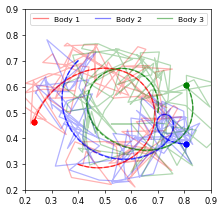

In [89]:
fig = plt.figure(figsize=[4,4], dpi=DPI)
colors = ['black', 'black', 'black']
plot_3body(x_sim, fig=fig, do_bodies=True, fmt='--', alpha=0.7)
plot_3body(xs_min[0].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=0.3)
plot_3body(xs_min[-1].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=0.5, legend=True)

In [90]:
xs_0 = xs_min[0].data.numpy().reshape(-1,3,2)
make_video(xs_0, path='./static/video_3body_0.mp4', interval=60, ms=23)
mp4 = open('./static/video_3body_0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [91]:
xs_f = xs_min[-1].data.numpy().reshape(-1,3,2)
make_video(xs_f, path='./static/video_3body_f.mp4', interval=60, ms=23)
mp4 = open('./static/video_3body_f.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

## Lennard-Jones gas simulation

In [92]:
dt = 0.2 ; N = 50
t_sim, x_sim = simulate_LJ(dt=dt, N=N, damping_coeff=0.99)
init_path = PerturbedPath(x_sim, N=N, sigma=8e-3) # [time, N*2]
# init_path.x.data[75:-2,:1] *= 0.7
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=3e-5,
                                       L_fn=lagrangian_LJ, dt=dt, opt='adam')

step=0000, S=1.634e-03 J*s, E_loss=0.000e+00, dt=0.1s
step=0033, S=1.157e-03 J*s, E_loss=0.000e+00, dt=1.8s
step=0066, S=8.178e-04 J*s, E_loss=0.000e+00, dt=1.7s
step=0099, S=5.830e-04 J*s, E_loss=0.000e+00, dt=1.7s
step=0132, S=4.209e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0165, S=3.093e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0198, S=2.330e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0231, S=1.810e-04 J*s, E_loss=0.000e+00, dt=1.7s
step=0264, S=1.458e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0297, S=1.223e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0330, S=1.064e-04 J*s, E_loss=0.000e+00, dt=1.6s
step=0363, S=9.576e-05 J*s, E_loss=0.000e+00, dt=1.6s
step=0396, S=8.852e-05 J*s, E_loss=0.000e+00, dt=1.6s
step=0429, S=8.353e-05 J*s, E_loss=0.000e+00, dt=1.6s
step=0462, S=7.998e-05 J*s, E_loss=0.000e+00, dt=1.6s
step=0495, S=7.736e-05 J*s, E_loss=0.000e+00, dt=1.5s


3.085949488053097e-05
2.7971835336094995e-06


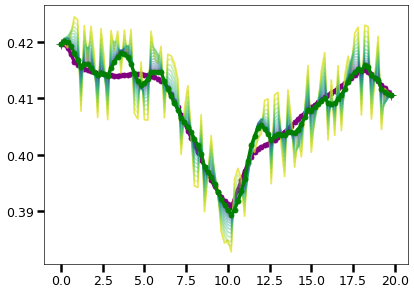

In [93]:
name = 'LJ'
N = x_sim.shape[-2]
k = 30

def gas_xcoord(xs, N=N, k=k):
    return xs.reshape(-1,N*2)[...,k]

ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=gas_xcoord)

0.00011106502585008808, 3.299190884042319e-05, 7.807311700966489e-05


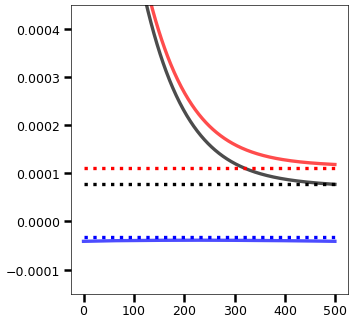

In [94]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_LJ, ylim=(-0.00015, 0.00045))

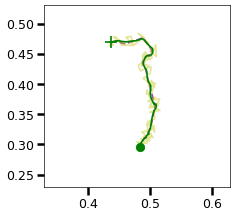

In [95]:
def plot_particle(x, i, do_bodies=False, colors=None, fig=None, ls='-', color='k', **kwargs):
    if fig is None:
        plt.figure(figsize=[4,4], dpi=80)
    plt.plot(x[:, i, 0], x[:, i, 1], ls=ls, color=color, linewidth=2, **kwargs)
    if do_bodies:
        plt.plot(x[-1,i,0], x[-1,i,1], '.', color='g', markersize=20)
        plt.plot(x[0,i,0], x[0,i,1], '+', color='g', markersize=15, mew=2)
    plt.xlim(0.2,0.85) ; plt.ylim(0.2,0.85)

N = x_sim.shape[-2]
# obj = 4
# obj = 8
obj = 3
fig = plt.figure(figsize=[4,4], dpi=DPI)
plot_particle(x_sim, obj, fig=fig, do_bodies=False, ls='--', color='purple', alpha=0.7)
plot_particle(xs_min[0].reshape(-1,N,2), obj, fig=fig, do_bodies=False, color='y', alpha=0.4)
plot_particle(xs_min[-1].reshape(-1,N,2), obj, fig=fig, do_bodies=True, color='g', alpha=1)
plt.xlim(0.33, .63)
plt.ylim(0.23, .53)

plt.tick_params(axis='both', length=9, width=3, labelsize=15)
if DPI > 250: fig.savefig('./static/dynamic_LJ_p{}.pdf'.format(obj))

In [99]:
xs_0 = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs_0, path='./static/video_gas_0.mp4', interval=60, ms=10)
mp4 = open('./static/video_gas_0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [100]:
xs_f = xs_min[-1].detach().numpy().reshape(-1,N,2)
make_video(xs_f, path='./static/video_gas_f.mp4', interval=30, ms=10)
mp4 = open('./static/video_gas_f.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

## Ephemeris dataset and simulation

Loading ./data/ephemeris_ablate.csv...


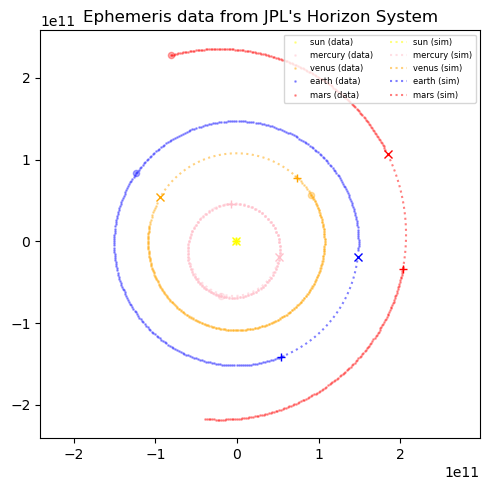

In [51]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [52]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True)

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

Loading ./data/ephemeris_ablate.csv...
step=0000, S=1.134e+35 J*s, E_loss=0.000e+00, dt=0.0s
step=0033, S=1.719e+36 J*s, E_loss=0.000e+00, dt=0.8s
step=0066, S=9.286e+34 J*s, E_loss=0.000e+00, dt=0.7s
step=0099, S=8.940e+33 J*s, E_loss=0.000e+00, dt=0.7s
step=0132, S=4.549e+33 J*s, E_loss=0.000e+00, dt=0.7s
step=0165, S=4.065e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0198, S=3.933e+33 J*s, E_loss=0.000e+00, dt=0.7s
step=0231, S=3.863e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0264, S=3.818e+33 J*s, E_loss=0.000e+00, dt=0.7s
step=0297, S=3.789e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0330, S=3.772e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0363, S=3.761e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0396, S=3.756e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0429, S=3.753e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0462, S=3.751e+33 J*s, E_loss=0.000e+00, dt=0.6s
step=0495, S=3.750e+33 J*s, E_loss=0.000e+00, dt=0.6s


1.4992017158390622e+20
7.116715480406711e+17


(1.2627271718748394e+33, -2.4871999313350316e+33, 3.749927103209871e+33)

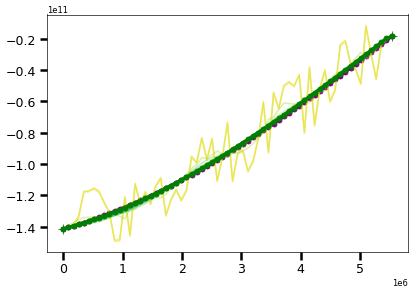

In [53]:
def earth_ycoord(xs, N=N):
    return xs.reshape(-1,N,2)[:, 3, 1]

ax_labels = {'title':'Earth Y-Coordinate',
             'x_label':'Time (hr)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}
name = 'Ephemeris'

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=earth_ycoord)
info['T'][-1], info['V'][-1], info['S'][-1]

1.2817408397602022e+33, -2.4771797544812632e+33, 3.7589205942414653e+33


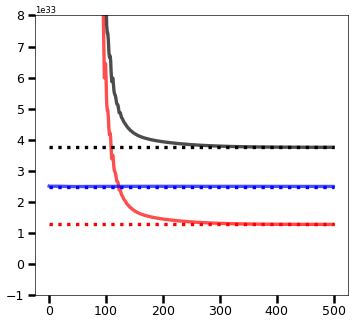

In [54]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}

L_planets = partial(lagrangian_planets, masses=get_masses(planets))
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=L_planets, ylim=(-1e33, .8e34))

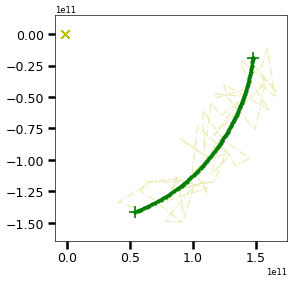

In [55]:
fig = plt.figure(figsize=[5,5], dpi=DPI)

xsi = xs_min[0].detach().numpy().reshape(-1,N,2)
xsf = xs_min[-1].detach().numpy().reshape(-1,N,2)
sim = x_sim.reshape(-1,N,2)

plt.plot(sim[:, 0, 0], sim[:, 0, 1], 'x', color='y', markersize=10)
plt.plot(sim[:, 3, 0], sim[:, 3, 1], '.-', color='purple', markersize=4)
plt.plot(xsi[:, 3, 0], xsi[:, 3, 1], '-.', color='y', alpha=0.3)
plt.plot(xsf[:, 3, 0], xsf[:, 3, 1], '.-', color='g', alpha=1, linewidth=3, markersize=8)
plt.plot(xsi[[0, -1], 3, 0], xsi[[0, -1], 3, 1], '+', color='g', markersize=15, mew=2)

plt.tick_params(axis='both', length=9, width=3, labelsize=15)
    

plt.axis('equal')
plt.show()
if DPI > 250: fig.savefig('./static/dynamic_earth_xy.png')

# 

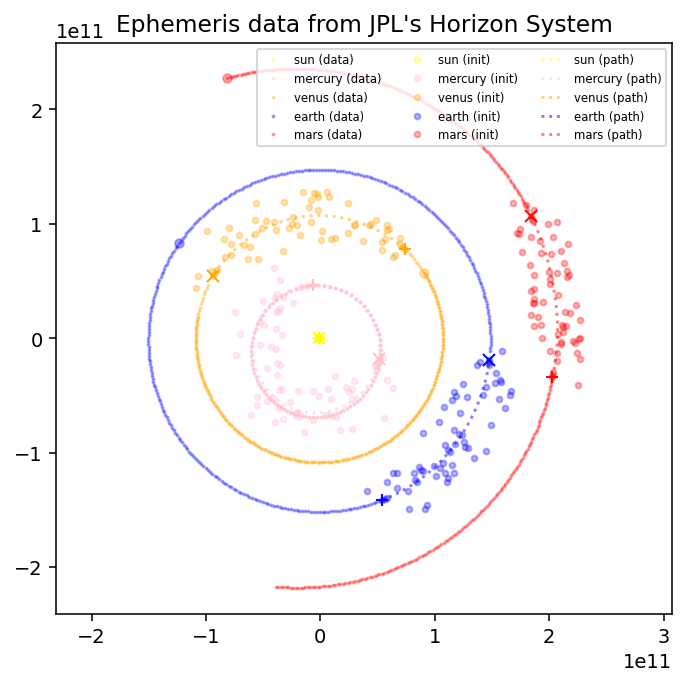

In [56]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()